# Gold Mining

## Introduction

Machine learning prototype for Zyfra, a company who develops efficiency solutions for heavy industry. We want to predict the gold recovered from gold ore by using the data on extraction and purification. Gold recovery is a complex process involving three stages: flotation, primary filtration and secondary filtration. Each one of these stages have their own input and output characteristics regarding different metals. We will use the data from the three stages to predict the gold recovered from the ore after flotation and filtration.


## Data Preprocess

### Objective

Three dataframes were provided: one with the data to train models, one for validation and the full dataset for reference. These dataframes will be checked for errors and missing values. We will also explore what information is available and define what features will be used for training. Data available in the training data that is not present in the validation data will be removed.

### Code

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

from joblib import dump

In [49]:
path_array = ['', '/', '/datasets/', './datasets/', '../datasets/']
CSVPATH = None

for i in path_array:
    try:
        pd.read_csv(i + 'gold_recovery_train.csv', nrows=1)
        CSVPATH = i
        break
    except:
        pass

if CSVPATH:
    print('Path found is', 'current folder' if CSVPATH == '' else CSVPATH)
else:
    print('No path found')

Path found is ../datasets/


In [50]:
csv_names = ['train', 'test', 'full']
df = {sheet: pd.read_csv(CSVPATH + 'gold_recovery_' + sheet + '.csv', nrows=100) for sheet in csv_names}

In [51]:
def optimize_types(df):
    df_dtypes = df.dtypes
    df_types = [i.name for i in df_dtypes.values]
    df_types = dict(zip(df.columns, df_types))
    return df_types

float_columns = df['full'].select_dtypes(include=['float64']).columns

for sheet in csv_names:
    for col in float_columns:
        if col in df[sheet]:
            df[sheet][col] = pd.to_numeric(df[sheet][col], downcast = 'float')

for sheet in csv_names:
    df_types = {sheet: optimize_types(df[sheet]) for sheet in csv_names}

In [52]:
df = {sheet: pd.read_csv(CSVPATH + 'gold_recovery_' + sheet + '.csv', dtype=df_types[sheet], parse_dates=['date']) for sheet in csv_names}

In [53]:
for sheet in csv_names:
    print('Number of duplicated rows for df ' + sheet + f': {df[sheet][df[sheet].duplicated()].shape[0]}')

Number of duplicated rows for df train: 0
Number of duplicated rows for df test: 0
Number of duplicated rows for df full: 0


In [54]:
for sheet in csv_names:
    print('Number of missing values for df ' + sheet + f': {df[sheet].isnull().sum().sum()}')

Number of missing values for df train: 30320
Number of missing values for df test: 2360
Number of missing values for df full: 36587


In [55]:
test_columns = df['test'].drop(['date'], axis=1).columns
train_columns = test_columns.union(['rougher.output.recovery', 'final.output.recovery'])

#### Observation

The names of the features available in the test dataset have been saved, along with the targets of our ML models. These is the data that will actually be used for model training. The rest of the information is only useful for exploratory data analysis. 

In [56]:
print(f"Number of missing date values: {pd.concat([df['train']['date'], df['test']['date'], df['full']['date']], axis=0).isna().sum().sum()}")

Number of missing date values: 0


In [57]:
test_train = []
for df_name in ['train', 'test']:
    # Sorting by date to get ordered data
    df[df_name] = df[df_name].sort_values('date', ascending=True).reset_index(drop=True)
    # Retrieve the corresponding data from the full dataframe
    test_train.append(df[df_name].sort_values('date', ascending=True).join(df['full'], lsuffix='', rsuffix='.full', how='left'))
    
train = test_train[0].loc[:, df['train'].columns]
test = test_train[1].loc[:, train_columns]

In [58]:
print('Top rows with missing values in train df (%):')
(train.isna().sum()/train.shape[0]*100).sort_values(ascending=False).head()

Top rows with missing values in train df (%):


rougher.output.recovery              15.260973
rougher.output.tail_ag               13.345196
rougher.output.tail_sol              13.339265
rougher.output.tail_au               13.339265
secondary_cleaner.output.tail_sol    11.779359
dtype: float64

In [59]:
train.loc[:, (train.columns == 'rougher.output.recovery') == False] = train.loc[:, (train.columns == 'rougher.output.recovery') == False].fillna(method='ffill')

In [60]:
print('Rows with missing values in train dataset after filling in (%):')
(train.isna().sum()/train.shape[0]).sort_values(ascending=False).head() * 100

Rows with missing values in train dataset after filling in (%):


rougher.output.recovery                               15.260973
secondary_cleaner.state.floatbank6_a_level             0.000000
rougher.calculation.floatbank10_sulfate_to_au_feed     0.000000
primary_cleaner.state.floatbank8_a_level               0.000000
primary_cleaner.state.floatbank8_b_air                 0.000000
dtype: float64

In [61]:
train = train.dropna()

In [62]:
print('Top rows with missing values in test df (%):')
(test.isna().sum()/test.shape[0]*100).sort_values(ascending=False).head()

Top rows with missing values in test df (%):


rougher.output.recovery               14.173497
final.output.recovery                 10.484973
rougher.input.floatbank11_xanthate     6.028005
primary_cleaner.input.sulfate          5.157104
primary_cleaner.input.depressant       4.849727
dtype: float64

In [63]:
test.loc[:, test.columns.isin(['rougher.output.recovery', 'final.output.recovery']) == False] = test.loc[:, test.columns.isin(['rougher.output.recovery', 'final.output.recovery']) == False ].fillna(method='ffill')


In [64]:
print('Rows with missing values in test dataset after filling in (%):')
(test.isna().sum()/test.shape[0]).sort_values(ascending=False).head() * 100

Rows with missing values in test dataset after filling in (%):


rougher.output.recovery               14.173497
final.output.recovery                 10.484973
rougher.input.feed_ag                  0.000000
rougher.state.floatbank10_a_air        0.000000
rougher.input.floatbank11_xanthate     0.000000
dtype: float64

In [65]:
test = test.dropna()

In [66]:
train['rougher.output.recovery'].describe()

count    14287.000000
mean        82.394196
std         15.096808
min          0.000000
25%         79.818371
50%         85.236000
75%         90.131691
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [67]:
def calc_recovery_rougher(row):
    C = row['rougher.output.concentrate_au'] # gold concentration right after flotation
    F = row['rougher.input.feed_au'] # gold concentration before flotation
    T = row['rougher.output.tail_au'] # gold in tails after flotation
    try:
        result = C * (F - T)/(F * (C - T )) * 100
    except:
        result = np.nan
    if result > 100:
        result = 100
    elif result <= 0:
        result = +0.0
    return result

In [68]:
rougher_recovery = train.apply(calc_recovery_rougher, axis=1)
rougher_recovery.name = 'calculated_rougher_recovery'

In [69]:
display(train[['rougher.output.recovery']].describe().merge(rougher_recovery.describe(), left_index=True, right_index=True))
print('The mean absolute error is: ', end='')
print(f"{metrics.mean_absolute_error(train['rougher.output.recovery'].fillna(0), rougher_recovery.fillna(0)):.2f}"
    )

,rougher.output.recovery,calculated_rougher_recovery
count,14287.000000,14287.000000
mean,82.394196,82.394201
std,15.096808,15.096808
min,0.000000,0.000000
25%,79.818371,79.818371
50%,85.236000,85.235997
75%,90.131691,90.131691
max,100.000000,100.000000


The mean absolute error is: 0.00


In [70]:
df['train'].columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [71]:
df['test'].columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

#### Observation

We can see that most of the features in the training data are not present in the test dataset. All of the output and calculation features are not available. These will be left out of the ML model.

In [72]:
print('Number of missing values in train df:', train.isna().sum().sum())

Number of missing values in train df: 0


In [73]:
print('Number of missing values in test df:', test.isna().sum().sum())

Number of missing values in test df: 0


### Results

Data preprocessing was extensive. Missing values were filled in with forward fill by using the previous values, since the data is a time series. The missing values for 'rougher.output.recovery' and 'final.output.recovery' were dropped from the datasets, since they are our targets for the models. The train dataset had much more features than the test dataset, so the columns pertaining the Machine Learning (ML) models were saved in the 'train_columns' variable. EDA will still use the full training dataset. Additionally, the target columns for the test dataset were obtained from the full dataset in order to correctly apply the ML training later on

From the provided training dataset, we have learned that the recovery is calculated as the ratio of the total weight of the gold ore to the total weight of the gold ore after purification. That validates the calculations provided in the simulation. The dataframe has been cleaned and the data is almost ready for training. We will perform exploratory data analysis to get rid of anormalities. It should be noted that the simulation for 'rougher.output.recovery' yielded great results and is a valid option to obtain the correct values instead of a ML model.


## Exploratory Data Analysis


### Objective


During this section, we will check data distributions and analyze some graphs regarding the data. Each graph will be used to determine if there are any outliers, because too many differences between training set and validation sets can lead to bad reuslts.


### Code

In [74]:
train.loc[:, train_columns].corr()['rougher.output.recovery'].sort_values(ascending=False).head(10)

rougher.output.recovery                     1.000000
final.output.recovery                       0.322067
primary_cleaner.input.sulfate               0.297871
rougher.input.floatbank10_xanthate          0.258139
secondary_cleaner.state.floatbank4_a_air    0.241429
secondary_cleaner.state.floatbank4_b_air    0.229738
rougher.input.feed_sol                      0.217336
rougher.input.floatbank11_xanthate          0.198506
rougher.input.feed_ag                       0.193330
rougher.input.feed_pb                       0.192980
Name: rougher.output.recovery, dtype: float64

In [75]:
train.loc[:, train_columns].corr()['final.output.recovery'].sort_values(ascending=False).head(10)

final.output.recovery                 1.000000
primary_cleaner.input.sulfate         0.382307
rougher.input.floatbank10_xanthate    0.327221
rougher.output.recovery               0.322067
rougher.input.feed_au                 0.316522
rougher.input.feed_ag                 0.302940
rougher.input.floatbank11_xanthate    0.264011
rougher.input.feed_sol                0.258949
rougher.state.floatbank10_a_air       0.222393
rougher.input.feed_pb                 0.214923
Name: final.output.recovery, dtype: float64

In [76]:
np.abs(train.loc[:, train_columns].corr()['rougher.output.recovery']).sort_values(ascending=True).head(10)

primary_cleaner.input.feed_size               0.003185
secondary_cleaner.state.floatbank5_a_level    0.004629
primary_cleaner.state.floatbank8_d_air        0.008323
primary_cleaner.state.floatbank8_d_level      0.009205
secondary_cleaner.state.floatbank3_a_level    0.010313
secondary_cleaner.state.floatbank6_a_air      0.015605
secondary_cleaner.state.floatbank2_b_level    0.023157
secondary_cleaner.state.floatbank2_a_level    0.024909
primary_cleaner.state.floatbank8_b_level      0.025978
rougher.input.feed_size                       0.028736
Name: rougher.output.recovery, dtype: float64

In [77]:
np.abs(train.loc[:, train_columns].corr()['final.output.recovery']).sort_values(ascending=True).head(10)

secondary_cleaner.state.floatbank2_b_level    0.006585
rougher.input.floatbank10_sulfate             0.007123
secondary_cleaner.state.floatbank3_b_level    0.007152
secondary_cleaner.state.floatbank2_a_level    0.007555
secondary_cleaner.state.floatbank5_a_level    0.014420
primary_cleaner.state.floatbank8_d_level      0.015782
rougher.input.feed_size                       0.021438
primary_cleaner.state.floatbank8_c_level      0.023584
primary_cleaner.state.floatbank8_a_level      0.024011
secondary_cleaner.state.floatbank5_b_level    0.026715
Name: final.output.recovery, dtype: float64

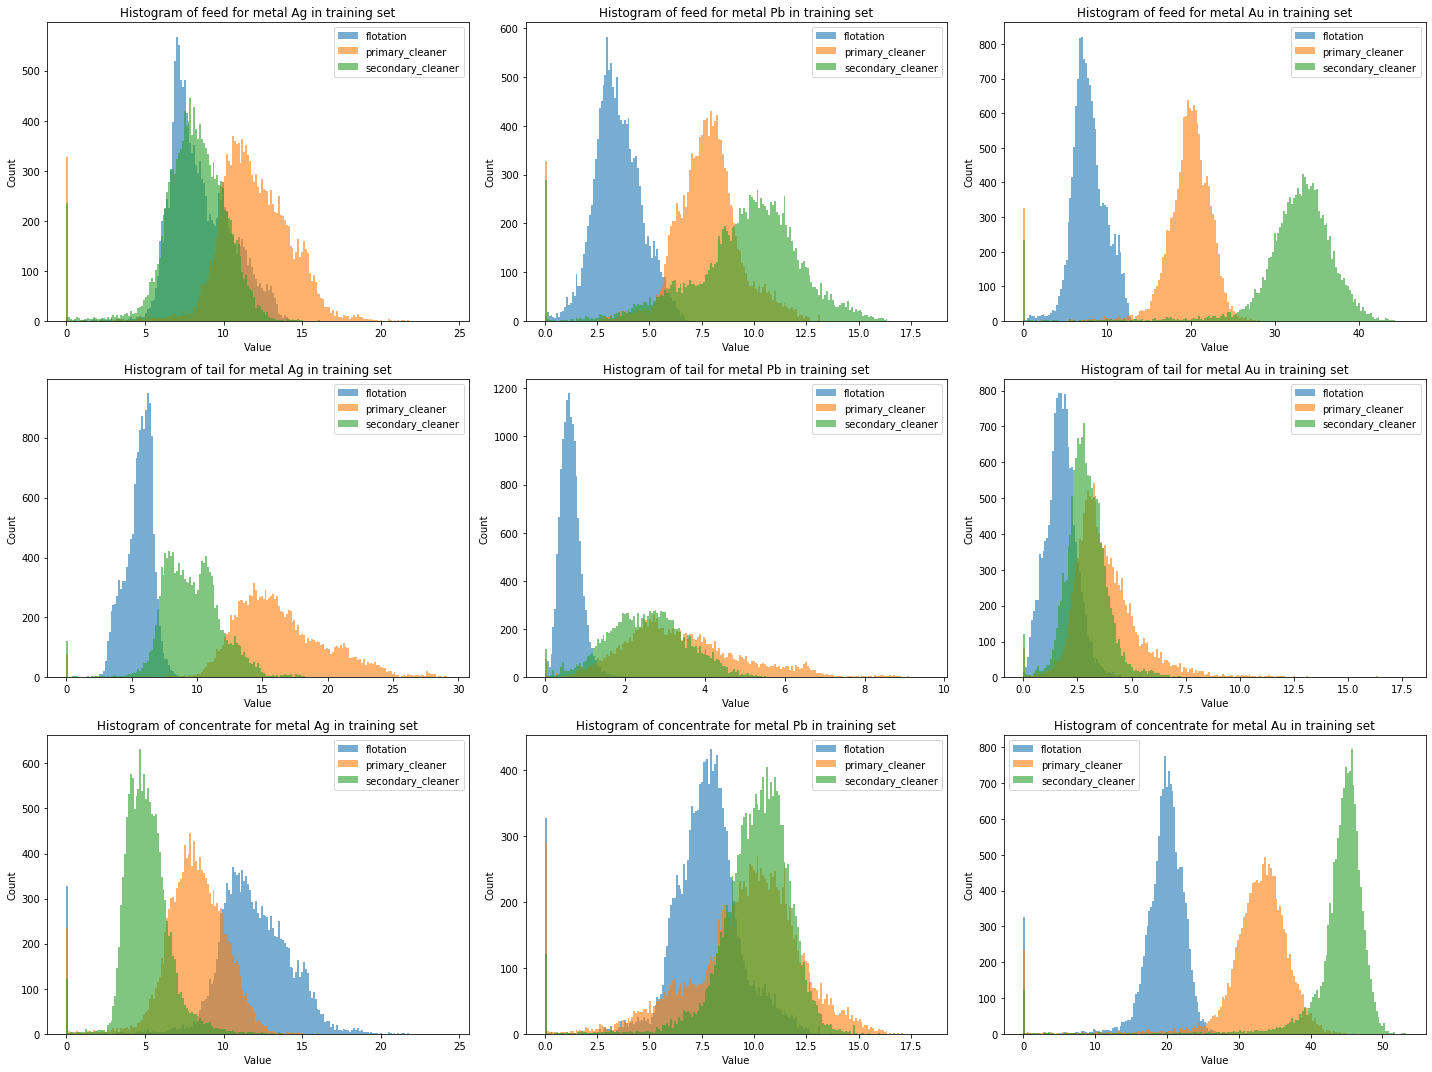

In [78]:
fig, axs = plt.subplots(3,3, figsize=(20, 15))
fig.set_tight_layout(True)

metals = ['ag', 'pb', 'au']
stages = {
    'feed': ['rougher.input.feed_',  'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_'], 
    
    'tail': ['rougher.output.tail_', 'primary_cleaner.output.tail_', 'final.output.tail_'],
    
    'concentrate': ['rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', 'final.output.concentrate_']
}
legend = ['flotation', 'primary_cleaner', 'secondary_cleaner']

for stage, c_i, type in zip(stages, range(len(stages)), ['feed', 'tail', 'concentrate']):
    for metal, m_i in zip(metals, range(len(metals))):
        maxrange = 0
        for col in stages[stage]:
            compare = abs(train[col + metal].max() - train[col + metal].min())
            if compare > maxrange:
                maxrange = compare
                bin_set = col
        bin = np.arange(train[bin_set + metal].min(), train[bin_set + metal].max(), maxrange/200)
        for col in stages[stage]:
            axs[c_i, m_i].hist(train[col + metal], bins=bin, alpha=0.6)
            axs[c_i, m_i].set_title('Histogram of ' + type + ' for metal ' + str.capitalize(metal) + ' in training set')
            axs[c_i, m_i].legend(legend)
            axs[c_i, m_i].set_xlabel('Value')
            axs[c_i, m_i].set_ylabel('Count')
            


plt.show()
    

*Graph Analysis*

The graphs above show the distributions of metal concentrations in the ore during flotation, primary filtration and secondary filtration. We can see that values can vary a lot from stage to stage for each metal. The main abnormalities found are zero values. According to the simulation, these values can generate calculation errors because of divisions by zero. However, the graphs that contain features are those describing the feed of metals during the flotation stage (blue graphs in the first row of the subplot). We notice that none of these graphs show outliers. Therefore, there will be no issues regarding the training of the model.

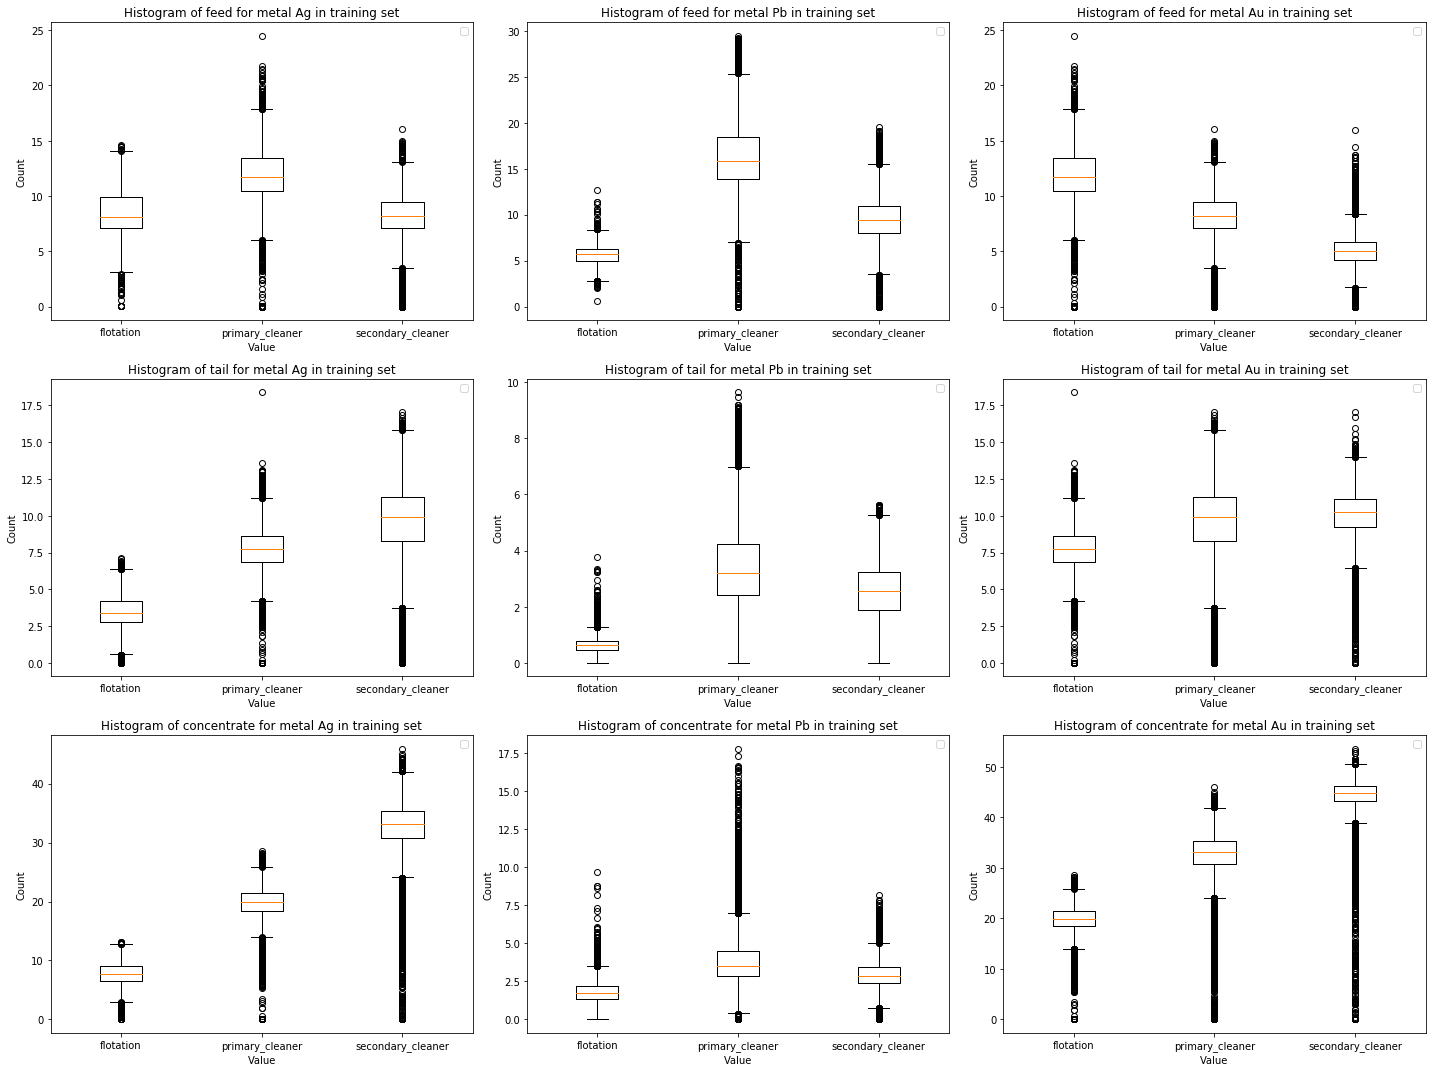

In [79]:
fig, axs = plt.subplots(3,3, figsize=(20, 15))
fig.set_tight_layout(True)

i = 0
boxplot_vector = {
    'ag': [],
    'pb': [],
    'au': []
}
for stage, c_i, type in zip(stages, range(len(stages)), ['feed', 'tail', 'concentrate']):
    for metal, m_i in zip(metals, range(len(metals))):
        maxrange = 0
        for col in stages[stage]:
            compare = abs(train[col + metal].max() - train[col + metal].min())
            if compare > maxrange:
                maxrange = compare
                bin_set = col
        bin = np.arange(train[bin_set + metal].min(), train[bin_set + metal].max(), maxrange/200)
        for col in stages[stage]:
            boxplot_vector[metal].append(train[col + metal])
            #axs[c_i, m_i].boxplot(train[col + metal])
            axs[c_i, m_i].set_title('Histogram of ' + type + ' for metal ' + str.capitalize(metal) + ' in training set')
            axs[c_i, m_i].legend(legend)
            axs[c_i, m_i].set_xlabel('Value')
            axs[c_i, m_i].set_ylabel('Count')

for i in range(3):
    for j in range(3):
        axs[i, j].boxplot(boxplot_vector[metals[i]][j*3:(j+1)*3], labels=['flotation', 'primary_cleaner', 'secondary_cleaner'])
        
plt.show()

*Graph Analysis*

By looking at the boxplots, we can have a better view on which columns possess the highest amount of outliers. They are mostly located in concentrate values for flotation and primary cleaner. We will use these columns to remove outliers and see if we can achieve better models.

In [80]:
train.shape

(14287, 87)

In [81]:
for stage in stages:
    for j in metals:
        for i in range(3):
                train = train[train[stages[stage][i] + j] > 0.5]
                
train = train[train['final.output.concentrate_au'] > 40]
train = train[train['primary_cleaner.output.concentrate_au'] > 25]
train = train[train['rougher.output.concentrate_au'] > 15]

In [82]:
train = train[ (train['rougher.input.feed_size'] < 100) & (train['rougher.input.feed_size'] > 9) ]
test = test[ (test['rougher.input.feed_size'] < 100) & (test['rougher.input.feed_size'] > 9) ]

In [83]:
feed_size = pd.concat([train['rougher.input.feed_size'], test['rougher.input.feed_size']], axis=1)

feed_size.describe()

,rougher.input.feed_size,rougher.input.feed_size
count,8271.000000,4855.000000
mean,57.020100,54.489521
std,11.326493,13.559534
min,9.659576,10.652137
25%,49.452007,43.897991
50%,54.582214,50.788559
75%,61.863136,61.619144
max,99.944870,99.938789


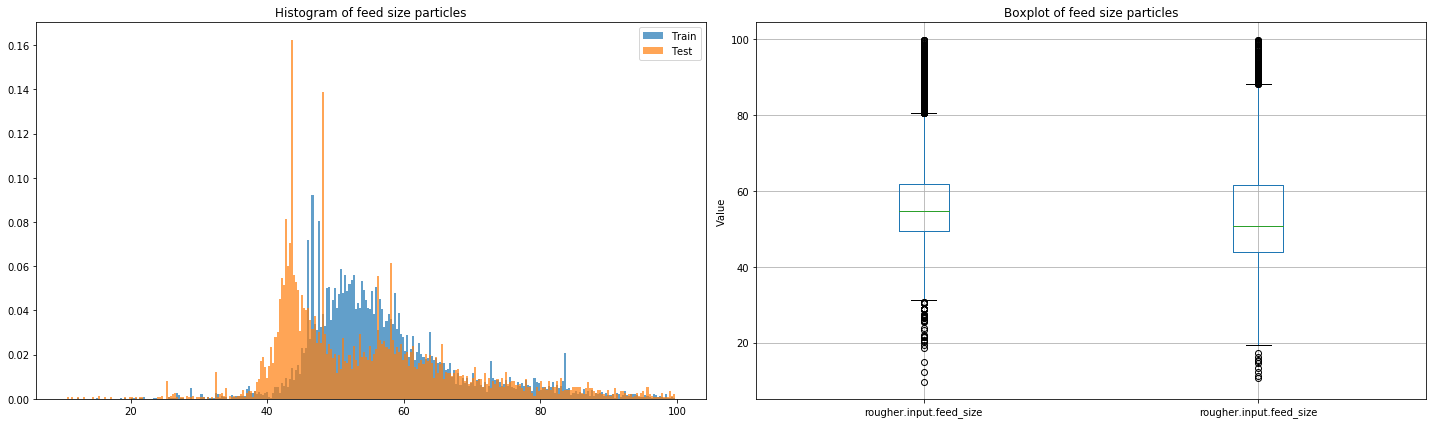

In [84]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
fig.set_tight_layout(True)

feed_size.boxplot()
axs[1].set_title('Boxplot of feed size particles')
axs[1].set_ylabel('Value')

for dframe in [train, test]:
    compare = abs(dframe['rougher.input.feed_size'].max() - dframe['rougher.input.feed_size'].min())
    if compare > maxrange:
        maxrange = compare
        bin_set = i
bin = np.arange(dframe['rougher.input.feed_size'].min(), dframe['rougher.input.feed_size'].max(), maxrange/300)

for dframe in [train, test]:
    axs[0].hist(dframe['rougher.input.feed_size'], bins=bin, density=True, alpha=0.7)
axs[0].set_title('Histogram of feed size particles')
axs[0].legend(['Train', 'Test'])

plt.show()

*Graph Analysis*

By looking at the graph above, we can see that there are differences between the distributions of feed size. At this point, the data has been filtered through and we have remove the majority of outliers. We can still see that the feed size distributions are not the same, but are close enough to each other for the model training.

### Results

We have checked data distributions to determine if there are problems in the data regarding outliers, or distributions so different that we will train a model that will not be able to predict the data. We have also checked correlations between the features and the target variable. We can see that many of the features are not considerably correlated with the target variables. It may be possible to optimize the model by these features.

<div class="alert alert-block alert-warning">
<b>Reviewer's comment.V.3.</b> <a class="tocSkip"></a>
    
Here we should plot boxplots for all columns.Like in previous step.  </div>

## Model Training

### Objective

After preparing the data and confirming distributions and correlations, we will train a model to predict the gold recovered from the ore. We will use the training data to train a model and evaluate the model performance with the validation set. The metric used will be the symmetric Mean Absolute Percentage Error (SMAPE). SMAPE is a metric that measures the percentage of differences between the predicted and the actual values. The SMAPE is calculated as the absolute percentage difference between the predicted and the actual values.

### Code

In [85]:
train = train.loc[:, train_columns].reset_index(drop=True)
test = test.loc[:, train_columns].reset_index(drop=True)
print('Size of training dataset is: ' + str(train.shape[0]))
print('Size of validation dataset is ' + str(test.shape[0]))

Size of training dataset is: 8271
Size of validation dataset is 4855


In [86]:
#train = train.loc[:, train.columns.str.contains('^[a-z+._\d]+floatbank[a-z+._\d]+') == False]
#test = test.loc[:, test.columns.str.contains('^[a-z+._\d]+floatbank[a-z+._\d]+') == False]

In [87]:
def target_features(df, tar_col, remove=[]):
    target = df[tar_col]
    remove.append(tar_col)
    features = df[[x for x in df if x not in remove]]
    return target, features

In [88]:
def smape(target, prediction):
    sum = 0.0
    for i, j in zip(target, prediction):
        parcel = abs(i - j)/(( abs(i) + abs(j) )/2)
        sum = sum + parcel
    result = sum/len(target)
    return result

smape_scorer = metrics.make_scorer(smape, greater_is_better=True)

In [89]:
def report(target, features=None, predictions=None, model=None, predictions_proba=None, classifier=True):
    """
    Prints a report of the model's performance. If regressor, add classifier=False
    """
    flag = 0
    if model != None:
        if predictions is not None:
            warnings.warn('Both model and predictions were passed. Ignoring model.')
        else:
            if features is None:
                raise ValueError('Features must be passed if model is passed.')
            predictions = model.predict(features)
            if classifier == True:
                predictions_proba = model.predict_proba(features)
    if predictions is not None:
        if classifier == True:
            print(f'Accuracy: {metrics.accuracy_score(target,predictions):.2%}') 
            print(f'Recall: {metrics.recall_score(target,predictions):.2%}')
            print(f'Precision: {metrics.precision_score(target,predictions):.2%}')
            print(f'F1 Score: {metrics.f1_score(target,predictions):.2%}')
        elif classifier == False:
            print(f'Mean Absolute Error: {metrics.mean_absolute_error(target,predictions):.2f}')
            print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(target,predictions)):.2f}') 
            print(f'R2 Score: {metrics.r2_score(target,predictions):.2f}')
            print(f'Predictions mean value: {np.mean(predictions):.2f} (Target mean is {np.mean(target):.2f})')
            print(f'Predictions median value: {np.median(predictions):.2f} (Target median is {np.median(target):.2f})')
            print(f'Smape Score: {smape(target, predictions):.2%}')
            target = pd.Series(target).reset_index(drop=True).sort_values()
            predictions = pd.Series(predictions)
            predictions = predictions.iloc[target.index].reset_index(drop=True)
            target = target.reset_index(drop=True)
            plt.plot(predictions, label='Predicted')
            plt.plot(target, label='Actual', color='orange')
            plt.legend(['Predicted', 'Actual'])
            plt.xlabel('Sample Number')
            plt.show()
    if predictions_proba is not None:
        fpr, tpr, thresholds = metrics.roc_curve(target, predictions_proba[:,1])
        print(f'AUC-ROC: {metrics.roc_auc_score(target,predictions_proba[:,1]):.2%}')
        flag = 1
    if flag == 1:
        return fpr, tpr, thresholds, predictions
    else:
        return predictions

In [90]:
train_target = []
train_feat = []

x, y = target_features(train, 'rougher.output.recovery', remove=['final.output.recovery', 'date'])
train_target.append(x)
train_feat.append(y)

x, y = target_features(train, 'final.output.recovery', remove=['date'])
train_target.append(x)
train_feat.append(y)

In [91]:
valid_target = []
valid_feat = []

x, y = target_features(test, 'rougher.output.recovery', remove=['final.output.recovery', 'date'])
valid_target.append(x)
valid_feat.append(y)

x, y = target_features(test, 'final.output.recovery', remove=['date'])
valid_target.append(x)
valid_feat.append(y)

In [92]:
#valid_feat[0] = valid_feat[0].loc[:, valid_feat[0].columns.str.contains('rougher[a-z+._\d]+') == True]
#train_feat[0] = train_feat[0].loc[:, train_feat[0].columns.str.contains('rougher[a-z+._\d]+') == True]

Report of linear model for 1:
Mean Absolute Error: 10.42
Root Mean Squared Error: 17.43
R2 Score: -0.60
Predictions mean value: 83.26 (Target mean is 77.77)
Predictions median value: 84.28 (Target median is 80.12)
Smape Score: 15.12%


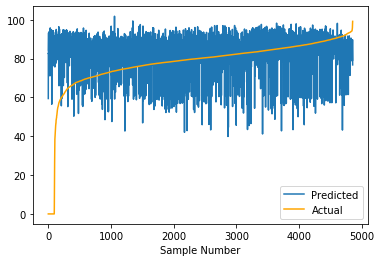



Report of linear model for 2:
Mean Absolute Error: 6.82
Root Mean Squared Error: 10.76
R2 Score: -0.23
Predictions mean value: 63.11 (Target mean is 64.26)
Predictions median value: 64.27 (Target median is 65.45)
Smape Score: 12.40%


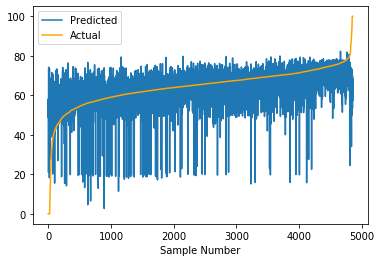



Smape of full model: 13.08%
Cross validation smape values are 
 8.23% 
 6.41% 
 6.47% 
 9.55%


In [93]:
# Launching linear model
linear_model = []
for i in range(2):
    linear_model.append(LinearRegression(normalize=True))

smape_value = []
valid_predict = []
for i in range(2):
    print(f'Report of linear model for {i+1}:')
    linear_model[i].fit(train_feat[i], train_target[i])
    valid_predict.append(linear_model[i].predict(valid_feat[i]))
    report(valid_target[i], predictions=valid_predict[i], classifier=False)
    smape_value.append(cross_val_score(linear_model[i], train_feat[i], train_target[i], scoring=smape_scorer, cv=4))
    print('\n')

total_smape = []
for i, j in zip(smape_value[0], smape_value[1]):
    total_smape.append(i*0.25 + j*0.75)
    
print(f'Smape of full model: {smape(valid_target[0], valid_predict[0]) * 0.25 + smape(valid_target[1], valid_predict[1])*0.75:.2%}')

print(f'Cross validation smape values are \n {total_smape[0]:.2%} \n {total_smape[1]:.2%} \n {total_smape[2]:.2%} \n {total_smape[3]:.2%}')


Report of tree model for 1:
Mean Absolute Error: 14.19
Root Mean Squared Error: 22.93
R2 Score: -1.76
Predictions mean value: 79.79 (Target mean is 77.77)
Predictions median value: 84.83 (Target median is 80.12)
Smape Score: 22.63%


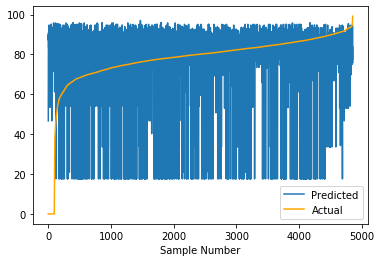



Report of tree model for 2:
Mean Absolute Error: 7.81
Root Mean Squared Error: 11.40
R2 Score: -0.38
Predictions mean value: 62.53 (Target mean is 64.26)
Predictions median value: 63.58 (Target median is 65.45)
Smape Score: 13.47%


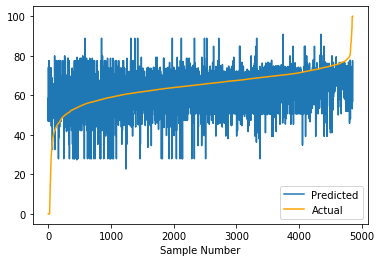



Smape of full model: 15.76%
Cross validation smape values are 
 12.06% 
 11.41% 
 10.16% 
 8.54%


In [94]:
# Launching tree model
tree_model = []
for i in range(2):
    tree_model.append(DecisionTreeRegressor(
        random_state = 1995
    ))

smape_value = []
valid_predict = []
for i in range(2):
    print(f'Report of tree model for {i+1}:')
    tree_model[i].fit(train_feat[i], train_target[i])
    valid_predict.append(tree_model[i].predict(valid_feat[i]))
    report(valid_target[i], predictions=valid_predict[i], classifier=False)
    smape_value.append(cross_val_score(tree_model[i], train_feat[i], train_target[i], scoring=smape_scorer, cv=4))
    print('\n')

total_smape = []
for i, j in zip(smape_value[0], smape_value[1]):
    total_smape.append(i*0.25 + j*0.75)
    
print(f'Smape of full model: {smape(valid_target[0], valid_predict[0]) * 0.25 + smape(valid_target[1], valid_predict[1])*0.75:.2%}')

print(f'Cross validation smape values are \n {total_smape[0]:.2%} \n {total_smape[1]:.2%} \n {total_smape[2]:.2%} \n {total_smape[3]:.2%}')


Report of forest model for 1:
Mean Absolute Error: 11.61
Root Mean Squared Error: 19.35
R2 Score: -0.97
Predictions mean value: 80.72 (Target mean is 77.77)
Predictions median value: 83.54 (Target median is 80.12)
Smape Score: 17.72%


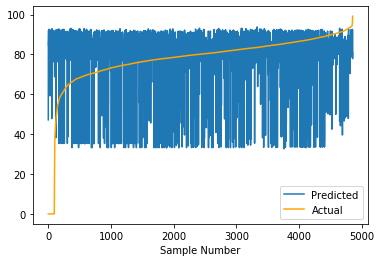



Report of forest model for 2:
Mean Absolute Error: 6.22
Root Mean Squared Error: 9.16
R2 Score: 0.11
Predictions mean value: 61.78 (Target mean is 64.26)
Predictions median value: 61.90 (Target median is 65.45)
Smape Score: 10.74%


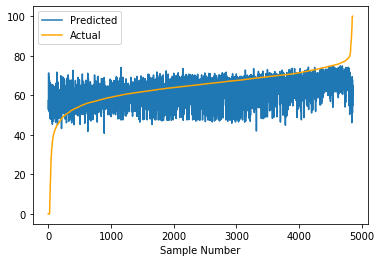



Smape of full model: 12.49%
Cross validation smape values are 
 7.48% 
 8.29% 
 7.25% 
 7.66%


In [95]:
# Launching forest model
forest_model = []
for i in range(2):
    forest_model.append(RandomForestRegressor(
        random_state = 1995,
        n_estimators=50
    ))

smape_value = []
valid_predict = []
for i in range(2):
    print(f'Report of forest model for {i+1}:')
    forest_model[i].fit(train_feat[i], train_target[i])
    valid_predict.append(forest_model[i].predict(valid_feat[i]))
    report(valid_target[i], predictions=valid_predict[i], classifier=False)
    smape_value.append(cross_val_score(forest_model[i], train_feat[i], train_target[i], scoring=smape_scorer, cv=4))
    print('\n')

total_smape = []
for i, j in zip(smape_value[0], smape_value[1]):
    total_smape.append(i*0.25 + j*0.75)
    
print(f'Smape of full model: {smape(valid_target[0], valid_predict[0]) * 0.25 + smape(valid_target[1], valid_predict[1])*0.75 :.2%}')

print(f'Cross validation smape values are \n {total_smape[0]:.2%} \n {total_smape[1]:.2%} \n {total_smape[2]:.2%} \n {total_smape[3]:.2%}')


In [96]:
#dump(forest_model[0], 'rougher.joblib')
#dump(forest_model[1], 'final.joblib')

OBS: Uncomment the code above to save the models

Below are the features used in the rougher model:

In [97]:
print(train_feat[0].columns.values)

['primary_cleaner.input.depressant' 'primary_cleaner.input.feed_size'
 'primary_cleaner.input.sulfate' 'primary_cleaner.input.xanthate'
 'primary_cleaner.state.floatbank8_a_air'
 'primary_cleaner.state.floatbank8_a_level'
 'primary_cleaner.state.floatbank8_b_air'
 'primary_cleaner.state.floatbank8_b_level'
 'primary_cleaner.state.floatbank8_c_air'
 'primary_cleaner.state.floatbank8_c_level'
 'primary_cleaner.state.floatbank8_d_air'
 'primary_cleaner.state.floatbank8_d_level' 'rougher.input.feed_ag'
 'rougher.input.feed_au' 'rougher.input.feed_pb' 'rougher.input.feed_rate'
 'rougher.input.feed_size' 'rougher.input.feed_sol'
 'rougher.input.floatbank10_sulfate' 'rougher.input.floatbank10_xanthate'
 'rougher.input.floatbank11_sulfate' 'rougher.input.floatbank11_xanthate'
 'rougher.state.floatbank10_a_air' 'rougher.state.floatbank10_a_level'
 'rougher.state.floatbank10_b_air' 'rougher.state.floatbank10_b_level'
 'rougher.state.floatbank10_c_air' 'rougher.state.floatbank10_c_level'
 'roughe

Next up are the features used in the final model:

In [98]:
print(train_feat[1].columns.values)

['primary_cleaner.input.depressant' 'primary_cleaner.input.feed_size'
 'primary_cleaner.input.sulfate' 'primary_cleaner.input.xanthate'
 'primary_cleaner.state.floatbank8_a_air'
 'primary_cleaner.state.floatbank8_a_level'
 'primary_cleaner.state.floatbank8_b_air'
 'primary_cleaner.state.floatbank8_b_level'
 'primary_cleaner.state.floatbank8_c_air'
 'primary_cleaner.state.floatbank8_c_level'
 'primary_cleaner.state.floatbank8_d_air'
 'primary_cleaner.state.floatbank8_d_level' 'rougher.input.feed_ag'
 'rougher.input.feed_au' 'rougher.input.feed_pb' 'rougher.input.feed_rate'
 'rougher.input.feed_size' 'rougher.input.feed_sol'
 'rougher.input.floatbank10_sulfate' 'rougher.input.floatbank10_xanthate'
 'rougher.input.floatbank11_sulfate' 'rougher.input.floatbank11_xanthate'
 'rougher.output.recovery' 'rougher.state.floatbank10_a_air'
 'rougher.state.floatbank10_a_level' 'rougher.state.floatbank10_b_air'
 'rougher.state.floatbank10_b_level' 'rougher.state.floatbank10_c_air'
 'rougher.state.fl

### Results

Of all trained models, the Random Forest model was the best performing. The model had a final SMAPE value of 13.25%, being cross validated with 4 models of subsets of the data. Plots comparing the target values and the predicted value were were made for each test performed. The model was trained on the full dataset. The cross validation has been done also with SMAPE scoring, and the final values obtained were between 7% and 10%. Since the floatbank information did not add up too much to the final model, this information was left out of the training and features, making the necessary input considerably easier to obtain. These models are considered our final product in this project.

## Conclusion

The data provided consisted of a training set, a test set and the full dataset. We have noticed many missing values during the data preprocessing, and the data was cleaned according to the columns available in the test set. Most of the output data was calculated after acquiring information, and specifically for the gold recovery calculation, most of it was not necessary. Although the data had information about flotation and filtration, we paid attention to not use data that would only be acquired in a posterior stage.

In this project we aimed to develop a trained model for the prediction of the gold recovered from the ore. We have used the data from the three stages of the gold recovery process to train a model, and the SMAPE metric to evaluate the model performance, obtaining a final value of 13.25%. The best performing method was the Random Forest model to train the models, and the cross validation confirmed the results. The full dataset was used to train the models. It is important to note that the simulation for 'rougher.output.recovery' yielded great results and is a valid option to obtain the correct values instead of the ML model.

One final remark is that floatbank information did not considerably improve the models, so that this information was not used in the training. Therefore, it will also be faster and easier to apply the model to new data. Addtionally, the simulation proves itself a valuable method to predict rougher recovery, instead of the ML model, and stands as an additional method available. This ML model may be used to optimize efficiency and expectations of gold ore production based on identified data instead of simulations.

